# **Item-based Collaborative Filtering Recommendations on MovieLens20M dataset**


## Objectives:

- Implement a item-based collaborative filtering algorithm.
- Utilize the `surprise` library for collaborative filtering.

----


### Item-Item collaborative filtering is mathematically very similar to user-based collaborative filtering. The main difference is that here we are going to compute the item-item similarity matrix using Pearson correlation coefficients. For that reason, most of the pieces contained in the present notebook are recycled from the previous user-based collaborative filtering notebook.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from IPython.display import display, Math, Latex

%matplotlib inline

In [2]:
# also set a random state
rs = 123

### Load and explore the dataset

First, let's load the datasets as `Pandas` dataframes and start some basic exploratory data analysis tasks on them.


In [3]:
ratings_df = pd.read_csv('rating.csv')

Let's first take a look at the datasets.

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
print('Number of rated movies:', ratings_df['movieId'].unique().size,'; number of unique users:', ratings_df['userId'].unique().size) 

Number of rated movies: 26744 ; number of unique users: 138493


### As we can see, we have significantly less items than users. That also means that the similarity matrix based on the items is less sparse and carries more information than the user-user similarity matrix. 

Since here we don't use the time stamp for the moment, let us remove it from the user-rating matrix (URM)

In [6]:
urm_df = ratings_df.drop('timestamp',axis=1) 
urm_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In the next steps, we create a sample from the original dataset sampling from 10000 movies.

# Sample user-item matrix with 1000 movies

Since there is much more users than movies in the dataset, we don't need that many movies as before. Here we can stay with a sample of the 1000 most frequently rated movies.

In [7]:
# here we sort the item in order of number of times the movie was rated. Later we take the 1000 most frequently rated movies.
list_of_movies_1000 = urm_df.groupby(['movieId']).size().axes[0][:1000]

In [8]:
sample_items_df = urm_df[urm_df['movieId'].isin(list_of_movies_1000)] # 

In [9]:
print('sample_users_df.shape', sample_items_df.shape)
print('Number of rated movies:', sample_items_df['movieId'].unique().size,'; number of unique users:', sample_items_df['userId'].unique().size) 

sample_users_df.shape (5399624, 3)
Number of rated movies: 1000 ; number of unique users: 137416


Let us obtain the average rating dataframes a given item receives from all users for the train and test sets. We call this dataframe `item_avg_rating`.

We also create a dictionary `item_id2idx_dict` to map from userId to matrix index and vice-versa.

In [10]:
item_avg_rating = sample_items_df.groupby('movieId')[['rating']].mean().reset_index().rename(columns={"rating": "avg"})

# we also create a dictionary to map from userId to matrix index and vice-versa
item_list = item_avg_rating.movieId.to_list()
item_id2idx_dict = {x: i for i, x in enumerate(item_list)}
item_idx2id_dict = {i: x for i, x in enumerate(item_list)}

item_avg_rating.shape

(1000, 2)

In [11]:
item_avg_rating

,movieId,avg
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592
...,...,...
995,1014,3.368290
996,1015,3.256498
997,1016,3.122945
998,1017,3.509988


### Now we can split the data into train and test sets. We set 10% to the test.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(sample_items_df, sample_items_df['rating'], test_size=0.1, random_state = rs, stratify=sample_items_df['movieId'])

In [13]:
print('x_test shape:', x_test.shape) 

print('x_train shape:', x_train.shape) 

x_test shape: (539963, 3)
x_train shape: (4859661, 3)


# Item-item similarity matrix 

Now, in order to compute the item-item similarity matrix, we want to transform the URM into a sparse 2D matrix. We achieve it by using the `pivot()` method.

In [14]:
urm_sparse_df = x_train.pivot(index='movieId', columns='userId',values='rating').fillna(0).reset_index().rename_axis(index=None,columns=None)

In [15]:
print(urm_sparse_df.shape)
urm_sparse_df.tail()

(1000, 137195)


,movieId,1,2,3,4,5,6,7,8,9,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
995,1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,1015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,1016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,1017,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We collect the numerical data of `urm_sparse_df` to a numpy array `urm`.

In [16]:
urm = urm_sparse_df.iloc[:,1:].to_numpy()
urm.shape 

(1000, 137194)

Now we compute the item-itemsimilarity matrix simply by using the numpy `corrcoef` method. It returns Pearson product-moment correlation coefficient matrix.

In [17]:
sim_item = np.corrcoef(urm)

In [18]:
# check the shape of the similarity matrix
sim_item.shape

(1000, 1000)

The similarity matrix is a symmetric matrix with dimension equal to the number of items (in the sample). Nex we plot the lower triangular part of the similarity matrix.

<Axes: >

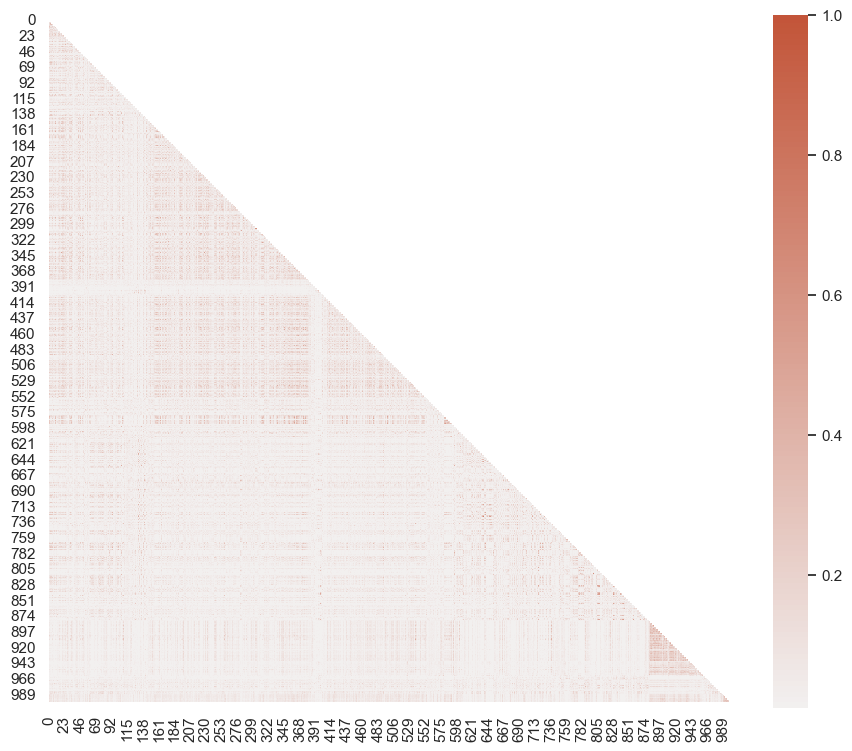

In [19]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_item, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_item, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)

The function `pred` takes the user u, item p, the URM matrix, and the dictionary to map index to movieId, and returns the predicted rating. The equation is given below.

$$
r(u,p) = \overline{r_u} + \frac{\sum_{i \in \Omega_p} sim(u,i).(r_{ip}-\overline{r_i})}{\sum_{i \in \Omega_p} |sim(u,i)|}
$$

The second part of the equation is nothing but a deviation term for the items's average rating. We can call it S(u,p).

$$
S(u,p) =  \frac{\sum_{i \in \Omega_p} sim(u,i).(r_{ip}-\overline{r_i})}{\sum_{i \in \Omega_p} |sim(u,i)|}
$$

$$
r(u,p) = \overline{r_u} + S(u,p)
$$

In [20]:
def pred(u, p, k):
    """
    The function pred computes the predicted rating given by an user u to an item p inspired on the KNN method for a given k.
    input: u: user, p: item, urm: user-rating matrix, k: the maximum number of similar user (like KNN) to be compared with.
    output: predicted rating
    """
    # Notice, the similarity matrix "sim_item", the "train_avg_rating" and the "x_train" dataframes, as well as the 
    # dictionary "train_id2idx_dict" are implicit to the function. Be sure these pieces are defined before calling the function.

    # S_up is the deviation factor that it is to be added to the average rating of item p.
    s_up = 0 

    urm = x_train.copy()

    # The average rating of item p.
    r_p = item_avg_rating['avg'][item_id2idx_dict[p]] 

    item_df = urm[urm['userId'] == u] # df of all items the user u has rated
    unique_items = item_df['movieId'].unique() # the subset of items rated by user u
    ix = item_id2idx_dict[p] # index on sim_items corresponding to item p

    # Here we create another dictionary to map userId to index in the just created item_df. 
    # Do not confuse id2idx_dict with item_id2idx_dict used with the item-item similarity matrix.
    item_listing = item_df.movieId.to_list()
    id2idx_dict = {x: a for a, x in zip(item_df.index.to_list(),item_listing)}

    # the length of unique_items can be very large and we dont need to iterate through all of them.  Many users will not be similar anyway.
    # We can create a threshold and take only k users who are similar by more than the threshold to compute predictions.
    items_threshold = 0.2
    # similar_items is a list of tuples (item_i , similarity(u,i)) where similarity(u,i) > threshold
    similar_items = [(a, sim_item[ix][item_id2idx_dict[a]]) for a in unique_items if sim_item[ix][item_id2idx_dict[a]] > items_threshold]
    similar_items_sorted = sorted(similar_items, key=lambda tup: tup[1], reverse=True) # sort users by similarity in descending order
    # the next list takes the first k most similar items
    unique_items_max = [a[0] for a in similar_items_sorted][:k]

    # If there are no items similar enough, return the items average because the predicted rating would not be accurate anyway.
    if len(unique_items_max) == 0 : 
        return r_p
    
    else:
        #
        for j in unique_items_max: 
            jx = item_id2idx_dict[j] # index on sim_item corresponding to item j

            if ix != jx :
                simui = sim_item[ix][jx] # i,j matrix element of the item-item similarity matrix.
                ruj = item_df['rating'][id2idx_dict[j]] # rating given by user u on item j
                rj_avg = item_avg_rating['avg'][jx] # average rating of user j to all items

                # mod is the denominator of the second part of equation above
                mod_eq = [sim_item[ix][item_id2idx_dict[h]] for h in unique_items_max]
                mod = np.sum(mod_eq)

                val = simui * (ruj - rj_avg) / mod
                s_up += val

        return r_p + s_up

# Baseline RMSE: Use the average rating of the item as basemodel prediction:

Now that we programmed the function to make predictions, let us first set the baseline for testing. The first test is using the average rating of an item as the predicted rating.

We can achieve it by simply applying a lambda function on our test set with the `item_avg_rating` dataframe.

Remember that the similarity matrix has been computed utilizing the x_train dataset, which means that our model has not seen the users scores on the test dataset.

In [21]:
test_user_avg = x_test.movieId.apply(lambda x: item_avg_rating['avg'][item_id2idx_dict[x]])

In [22]:
baseline = np.sqrt(mean_squared_error(test_user_avg,y_test))
print('RMSE of the basemodel:', baseline)

RMSE of the basemodel: 0.9474467208024974


With RMSE score of **0.9457**, our baseline is established. Next we compute the RMSE with the predicted ratings.

# Homemade item-item collaborative filtering 

Now we use our `pred` function to predic rating across the x_test dataset and compute the RMSE.

In [23]:
import concurrent.futures

# Function to unpack the tuple and pass it to pred()
def unpack_and_call(t):
    return pred(*t)

In [24]:
# Transform x_test dataframe to x_test_array such a way I get a list of tuples (user,item,k) to be passed as arguments to pred() with map()
xt = x_test[['userId', 'movieId']]
xt['K'] = 40 # set the third column k=40
x_test_array = xt.values
x_test_array.shape

(539963, 3)

In [25]:
# we execute the function pred() on the array in parallel using ThreadPoo
with concurrent.futures.ThreadPoolExecutor() as executor:
    pred_test = list(executor.map(unpack_and_call, x_test_array))

In [26]:
#pred_test = x_test.apply(lambda x: pred(x.userId, x.movieId, 20), axis=1 )

In [27]:
cf = np.sqrt(mean_squared_error(pred_test , y_test))
print('RMSE of our user-user CF model:', cf)

RMSE of our user-user CF model: 0.8674352442170263


With RMSE of **0.8674**, we have demonstrated that the simple item-item collaborative filtering approach is able to provide good estimatives for ratings.

# Item-Item collaborative filtering using Surprise library

Surprise is a Python sci-kit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms.

Next we will try to recompute the RMSE on the same sampled dataset to compare with our implimentation.

In [28]:
from surprise import KNNBasic, NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

In [29]:
sample_items_df.to_csv('sample_df.csv', index=False, header=list(sample_items_df.columns))

In [30]:
# create the reader object with Read on the rating dataset with columns user item rating
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("sample_df.csv", reader=reader)

In [31]:
trainset, testset = train_test_split(course_dataset, test_size=.1)

In [32]:
# check how many users and items we can use to fit a KNN model:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the training set")

Total 137196 users and 1000 items in the training set


Perform KNN-based collaborative filtering on the user-item interaction matrix

In [33]:
sim_options = {'name': 'pearson', 'user_based': False} # user_based = False means item-based

# Build the KNNBasic algorithm, and train it.
model_KNN = KNNBasic(k=20, min_k=1, sim_options=sim_options, random_state = rs)


In [34]:
%%time
# Train the model
model_KNN.fit(trainset)
# Make predictions with KNN on the test set
predictions_knn = model_KNN.test(testset)
# Evaluate the model
kmm40 = accuracy.rmse(predictions_knn)
print('RMSE of model KNN:', kmm40)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8710
RMSE of model KNN: 0.8710346649023443
CPU times: user 20.6 s, sys: 90.1 ms, total: 20.7 s
Wall time: 20.7 s


The RMSE here, **0.8710** to our implemented CF. 
Nonetheless, the computing time was significantly less compared to our simple implementation.